In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import torch
from torch import nn
import open_clip
import matplotlib.pyplot as plt

In [2]:
celeb_name = "Elon_Musk"
pair = "ViT-B-32 laion400m_e32"

model_name, ckpt = pair.split(' ')
mask_root = Path(f'grads/name/{celeb_name}_{model_name}_{ckpt}')

forget_importances = torch.load(mask_root/'forget_grads.pt', map_location='cpu')
retain_importances = torch.load(mask_root/'train_grads.pt', map_location='cpu')

In [3]:
# get statistics of the importance values

all_elements_forget = torch.cat([tensor.flatten() for tensor in forget_importances.values()])
all_elements_retain = torch.cat([tensor.flatten() for tensor in retain_importances.values()])
nan_percentage_forget = torch.isnan(all_elements_forget).sum() / len(all_elements_forget)
nan_percentage_retain = torch.isnan(all_elements_retain).sum() / len(all_elements_retain)
if nan_percentage_forget > 0:
    print(f"nan_percentage_forget: {nan_percentage_forget}")
if nan_percentage_retain > 0:
    print(f"nan_percentage_retain: {nan_percentage_retain}")
print(f'Forget importance: min {all_elements_forget.min()}, max {all_elements_forget.max()}, mean {all_elements_forget.mean()}, std {all_elements_forget.std()}')
print(f'Retain importance: min {all_elements_retain.min()}, max {all_elements_retain.max()}, mean {all_elements_retain.mean()}, std {all_elements_retain.std()}')

Forget importance: min -0.25643134117126465, max 0.19190551340579987, mean -5.335078512302971e-08, std 0.00019827073265332729
Retain importance: min -0.012224145233631134, max 0.015554971061646938, mean -3.91441457026076e-09, std 3.638578345999122e-05


In [ ]:
# get forget importance ratio

# load pretrained model
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=ckpt)
model_params = {}
for idx, (k, p) in enumerate(model.named_parameters()):
    model_params[k] = p.data


forget_ratio_dict = {}
for layer_name in model_params:
    params_norm = torch.norm(model_params[layer_name]).item()
    grad_norm = torch.norm(forget_importances[layer_name]).item()
    if grad_norm > 0:
        forget_ratio_dict[layer_name] = grad_norm / params_norm
    
# sort
ranked_forget_ratio = {k: v for k, v in sorted(forget_ratio_dict.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
# get alignment 

cos = nn.CosineSimilarity(dim=0, eps=1e-6)
cosine_dict = {}
for layer_name in model_params:
    if len(retain_importances[layer_name].shape) > 0:
        cosine_dict[layer_name] = abs(cos(retain_importances[layer_name].flatten(), forget_importances[layer_name].flatten())).item()


ranked_cos_name_list = []
ranked_cos = {k: v for k, v in sorted(cosine_dict.items(), key=lambda item: item[1], reverse=True)}

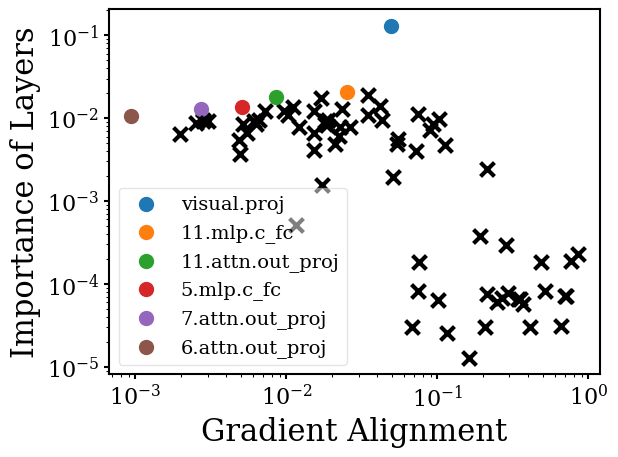

In [41]:
part = 'vision'
# part = 'language'


# make plot
name_list = []
x_cos_list = []
y_ratio_list = []
for key in ranked_cos:
    if "bias" in key: continue
    if 'logit_scale' in key: continue
    if 'position' in key: continue
    if 'embedding' in key: continue
    # if '.ln_' in key: continue
    if part == "vision" and "visual" not in key: continue
    if part != "vision" and "visual" in key: continue
    
    name_list.append(key)
    x_cos_list.append(ranked_cos[key])
    y_ratio_list.append(ranked_forget_ratio[key])


def identify_pareto(scores):
    # Initialize a list to store the index of Pareto points
    pareto_index = []
    # Loop through all points
    for i, (x, y) in enumerate(scores):
        dominated = False
        for j, (x2, y2) in enumerate(scores):
            # Check if point (x2, y2) dominates (x, y)
            if x2 < x and y2 > y:
                dominated = True
                break
        if not dominated:
            pareto_index.append(i)
    return pareto_index


# Use the function to find Pareto front
pareto_indices = identify_pareto(list(zip(x_cos_list, y_ratio_list)))

# Set font size and family globally
plt.rcParams["font.size"] = 14  # Increase font size to 14
plt.rcParams["font.family"] = "serif"


# # Increase font size
font_size = 14  # Increased from 12
plt.rcParams['font.size'] = font_size
plt.rcParams['axes.labelsize'] = font_size + 8
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size + 2
plt.rcParams['ytick.labelsize'] = font_size + 2
plt.rcParams['legend.fontsize'] = font_size

line_width = 3
plt.rcParams['lines.linewidth'] = line_width
plt.rcParams['axes.linewidth'] = line_width / 2  # Usually thinner than plot lines
plt.rcParams['xtick.major.width'] = line_width / 2
plt.rcParams['ytick.major.width'] = line_width / 2
plt.rcParams['xtick.minor.width'] = line_width / 4
plt.rcParams['ytick.minor.width'] = line_width / 4


fig = plt.figure()

for idx, (name, x, y) in enumerate(zip(name_list, x_cos_list, y_ratio_list)):
    # Modify label for shorter representation (optional)
    if part == 'vision':
        label_name = name.replace('visual.transformer.resblocks.', '').replace('.weight', '').replace('_weight', '')
    else:
        label_name = name.replace('transformer.resblocks.', '').replace('.weight', '').replace('_weight', '')
    
    if idx in pareto_indices:
        plt.scatter(x, y, label=label_name, s=100)
    else:
        plt.scatter(x, y, marker='x', c='k', s=100)

plt.xscale('log')
plt.yscale('log')

# Use prop argument with font size and family for legend
plt.legend(loc='lower left', bbox_to_anchor=(0, 0), prop={'size': 14}, fancybox=True, framealpha=0.5)

# Set font size and weight for labels
plt.xlabel("Gradient Alignment")
plt.ylabel("Importance of Layers")

plt.tight_layout()
plt.savefig(f'pareto-{part}-elon.pdf')

plt.show()

## Unlearning plot

In [83]:
import re
from pathlib import Path
import numpy as np

def parse_file(file_path):
    iterations = []
    ratios = []
    fgt_acc1 = []
    fgt_acc5 = []
    test_acc1 = []
    test_acc5 = []
    celeb_top1 = []
    celeb_top5 = []

    with open(file_path, 'r') as file:
        for line in file:
            iter_match = re.search(r'iter: (\d+)', line)
            ratio_match = re.search(r'ratio: ([\d\-.]+)', line)
            fgt_acc1_match = re.search(r'fgt_acc@1: ([\d.]+)%', line)
            fgt_acc5_match = re.search(r'fgt_acc@5: ([\d.]+)%', line)
            test_acc1_match = re.search(r'test_acc@1: ([\d.]+)%', line)
            test_acc5_match = re.search(r'test_acc@5: ([\d.]+)%', line)
            celeb_top1_match = re.search(r'celeb top1: ([\d.]+)', line)
            celeb_top5_match = re.search(r'celeb top5: ([\d.]+)', line)

            if iter_match:
                iterations.append(int(iter_match.group(1)))
            if ratio_match:
                ratios.append(float(ratio_match.group(1)))
            if fgt_acc1_match:
                fgt_acc1.append(float(fgt_acc1_match.group(1)))
            if fgt_acc5_match:
                fgt_acc5.append(float(fgt_acc5_match.group(1)))
            if test_acc1_match:
                test_acc1.append(float(test_acc1_match.group(1)))
            if test_acc5_match:
                test_acc5.append(float(test_acc5_match.group(1)))
            if celeb_top1_match:
                celeb_top1.append(float(celeb_top1_match.group(1)))
            if celeb_top5_match:
                celeb_top5.append(float(celeb_top5_match.group(1)))

    return {
        'iterations': sorted(list(set(iterations))),
        'ratios': sorted(list(set(ratios)), reverse=True),
        'fgt_acc1': fgt_acc1,
        'fgt_acc5': fgt_acc5,
        'test_acc1': test_acc1,
        'test_acc5': test_acc5,
        'celeb_top1': celeb_top1,
        'celeb_top5': celeb_top5
    }


In [86]:
celeb_name = "Elon_Musk"

pair = "ViT-B-32 laion400m_e32"
model_name, ckpt = pair.split(' ')
part = 'vision'
layer_name = "visual.transformer.resblocks.11.attn.out_proj.weight"

# part = 'language'
# layer_name = "transformer.resblocks.0.attn.out_proj.weight"

save_root = Path(f'figs/output_linear/{celeb_name}/{model_name}-{part}-{layer_name}')

txt_path = save_root / 'log.txt'
results = parse_file(txt_path)

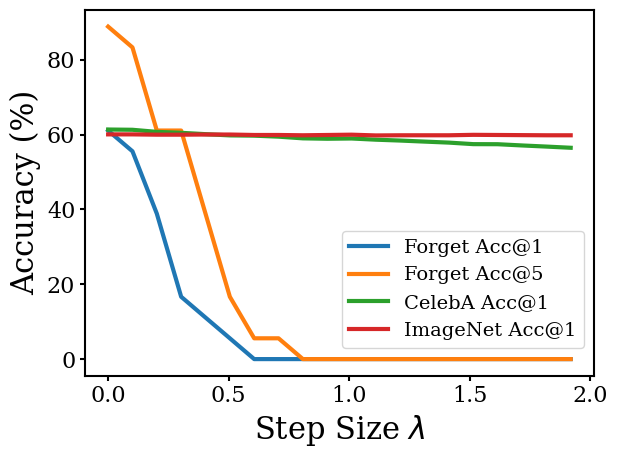

In [87]:
n = 20

mia_avg = [item[0] for item in results['MIA']]
mia_std = [item[1] for item in results['MIA']]
x = np.abs(results['ratios'][:n])
plt.plot(x, results['fgt_acc1'][:n], label='Forget Acc@1')
plt.plot(x, results['fgt_acc5'][:n], label='Forget Acc@5')
plt.plot(x, results['celeb_top1'][:n], label='CelebA Acc@1')
plt.plot(x, results['test_acc1'][:n], label='ImageNet Acc@1')

plt.ylabel('Accuracy (%)')
plt.xlabel(r'Step Size $\lambda$')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.05))
# plt.legend()
plt.tight_layout()
plt.savefig(f'{celeb_name}-{pair}-{part}-{layer_name}.pdf')
plt.show()

## Curves for comparison

In [68]:
import re
from pathlib import Path

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import torch

def parse_file(file_path):
    """extract info from txt files"""
    iterations = []
    ratios = []
    fgt_acc1 = []
    fgt_acc5 = []
    test_acc1 = []
    test_acc5 = []
    MIA = []
    celeb_top1 = []
    celeb_top5 = []

    pattern = r'iter: (\d+), fgt_acc@1: ([\d\.]+), fgt_acc@5: ([\d\.]+), celeba100@1: ([\d\.]+), celeba100@5: ([\d\.]+), test_acc@1: ([\d\.]+), test_acc@5: ([\d\.]+), MIA: ([\d\.]+)±([\d\.]+)'
    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                iterations.append(int(match.groups()[0]))
                fgt_acc1.append(float(match.groups()[1]))
                fgt_acc5.append(float(match.groups()[2]))
                test_acc1.append(float(match.groups()[5]))
                test_acc5.append(float(match.groups()[6]))
                celeb_top1.append(float(match.groups()[3]))
                celeb_top5.append(float(match.groups()[4]))
            else:
                print("No match found")

    return {
        'iterations': sorted(list(set(iterations))),
        'fgt_acc1': fgt_acc1,
        'fgt_acc5': fgt_acc5,
        'test_acc1': test_acc1,
        'test_acc5': test_acc5,
        'celeb_top1': celeb_top1,
        'celeb_top5': celeb_top5
    }


def calculate_averages(data_list):
    # Initialize a dictionary to hold the sum of each field
    sums = {}
    # Initialize the result dictionary for averages
    averages = {}
    
    # Process each item in the list
    for data in data_list:
        for key, value in data.items():
            # Handle numeric values
            if isinstance(value, (int, float)):
                if key in sums:
                    sums[key] += value
                else:
                    sums[key] = value
            # Handle tuple values (for example 'MIA')
            elif isinstance(value, tuple) and all(isinstance(num, (int, float)) for num in value):
                if key not in sums:
                    sums[key] = tuple(0 for _ in value)
                sums[key] = tuple(sum(x) for x in zip(sums[key], value))
    
    # Calculate averages
    num_items = len(data_list)
    for key, sum_value in sums.items():
        if isinstance(sum_value, tuple):
            averages[key] = tuple(x / num_items for x in sum_value)
        else:
            averages[key] = sum_value / num_items
    
    return averages

In [69]:
# salun

folder_root = Path('../results')

method = 'salun'
for method in ['raw', 'ft', 'ga', 'gaft', 'salun', 'ssd']:
    files = folder_root.glob(f"*_{method}.txt")
        
    data_list = []
    for file in sorted(list(files)):
        results = parse_file(file)
    
        # Find the first zero or the lowest fgt_acc1
        first_zero_index = None
        min_value = float('inf')
        min_index = None
        
        for i, acc in enumerate(results['fgt_acc1']):
            if acc == 0 and first_zero_index is None:
                first_zero_index = i
                break
            if acc < min_value:
                min_value = acc
                min_index = i
        
        # Use first zero if available, otherwise use the index of the minimum value
        target_index = first_zero_index if first_zero_index is not None else min_index
            
        # Output the data at the found index
        output = {key: values[target_index] for key, values in results.items()}
        data_list.append(output)
    
    averages = calculate_averages(data_list)

    s = f'{method}: '
    for i in averages:
        if isinstance(averages[i], (int, float)):
            s += f"{i}: {averages[i]*100:.2f}%, "
        else:
            s += f"{i}: {averages[i][0]:.2f} ± {averages[i][1]:.2f} "
    print(s)

raw: iterations: 0.00%, fgt_acc1: 73.05%, fgt_acc5: 92.22%, test_acc1: 60.12%, test_acc5: 85.52%, MIA: 72.81 ± 0.87 celeb_top1: 61.38%, celeb_top5: 82.33%, 
ft: iterations: 160.00%, fgt_acc1: 66.08%, fgt_acc5: 90.10%, test_acc1: 60.36%, test_acc5: 85.27%, MIA: 72.42 ± 0.90 celeb_top1: 60.70%, celeb_top5: 81.74%, 
ga: iterations: 0.00%, fgt_acc1: 0.00%, fgt_acc5: 0.00%, test_acc1: 35.88%, test_acc5: 52.20%, MIA: 89.96 ± 0.49 celeb_top1: 24.92%, celeb_top5: 38.27%, 
gaft: iterations: 0.00%, fgt_acc1: 0.00%, fgt_acc5: 0.00%, test_acc1: 55.52%, test_acc5: 81.42%, MIA: 90.75 ± 0.52 celeb_top1: 25.71%, celeb_top5: 41.20%, 
salun: iterations: 0.00%, fgt_acc1: 0.00%, fgt_acc5: 0.00%, test_acc1: 55.45%, test_acc5: 81.23%, MIA: 90.55 ± 0.57 celeb_top1: 26.11%, celeb_top5: 41.30%, 
ssd: iterations: 0.00%, fgt_acc1: 0.00%, fgt_acc5: 0.00%, test_acc1: 51.84%, test_acc5: 75.14%, MIA: 80.58 ± 0.85 celeb_top1: 35.96%, celeb_top5: 51.54%, 


In [81]:
folder_root = Path('../results')

celeb_name = 'Elon_Musk'
pair = "ViT-B-32 laion400m_e32"
model_name, ckpt = pair.split(' ')
# method = 'ga' # 'ga'
method = 'gaft' # 'gaft'
ga_file = folder_root.glob(f"2024_07_07*_{celeb_name}_{method}_lr1e-07.txt")
raw_file = folder_root.glob(f"2024_07_07*_{celeb_name}_raw.txt")
results_raw = parse_file(list(raw_file)[0])

fgt_acc1_list = []
fgt_acc5_list = []
test_acc1_list = []
celeb_top1_list = []
for file in sorted(list(ga_file)):
    results = parse_file(file)

    fgt_acc1_list.append(results_raw['fgt_acc1'] + results['fgt_acc1'])
    fgt_acc5_list.append(results_raw['fgt_acc5'] + results['fgt_acc5'])
    test_acc1_list.append(results_raw['test_acc1'] + results['test_acc1'])
    celeb_top1_list.append(results_raw['celeb_top1'] + results['celeb_top1'])
    

fgt_acc1_avg = np.mean(fgt_acc1_list,axis=0)*100
fgt_acc5_avg = np.mean(fgt_acc5_list,axis=0)*100
test_acc1_avg = np.mean(test_acc1_list,axis=0)*100
celeb_top1_avg = np.mean(celeb_top1_list,axis=0)*100

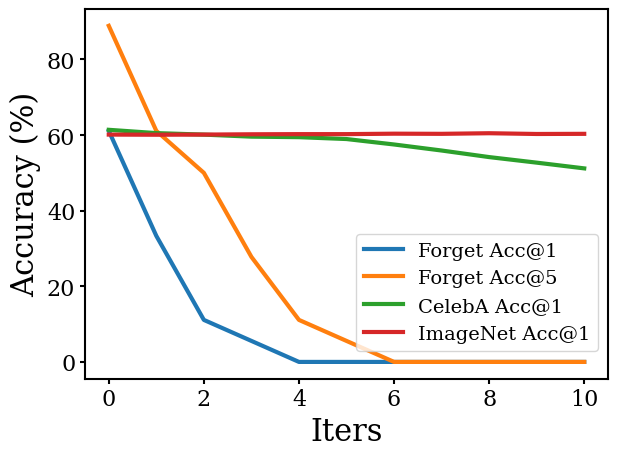

In [82]:
fig, ax1 = plt.subplots()
ax1.plot(x, fgt_acc1_avg, label='Forget Acc@1')
ax1.plot(x, fgt_acc5_avg, label='Forget Acc@5')
ax1.plot(x, celeb_top1_avg, label='CelebA Acc@1')
ax1.plot(x, test_acc1_avg, label='ImageNet Acc@1')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.05))
ax1.set_xlabel('Iters')
ax1.set_ylabel('Accuracy (%)')

plt.tight_layout()
save_path = f'{celeb_name}-{model_name}-{method}.pdf'
plt.savefig(save_path)

plt.show()